In [1]:
!pip install pycuda

Imports.

In [0]:
import numpy as np
from numpy import linalg as LA

import pycuda.driver as cuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule

import cv2
import matplotlib.pyplot as plt

iDivUp function: if ```b``` divides ```a```, then ```a/b``` is returned, otherwise the function returns the integer division between ```a``` and ```b``` ```+1```.

In [0]:
###################
# iDivUp FUNCTION #
###################
def iDivUp(a, b):
    # Round a / b to nearest higher integer value
    a = np.int32(a)
    b = np.int32(b)
    return (a / b + 1) if (a % b != 0) else (a / b)

The fftshift kernel. Image is ```M``` rows by ```N``` columns.

In [0]:
mod = SourceModule("""
#include <stdio.h>
__global__ void fftshift2DKernel(double *input, double *output, const int M, const int N) 
{
    
    const int tidx = threadIdx.x + blockIdx.x * blockDim.x;
    const int tidy = threadIdx.y + blockIdx.y * blockDim.y;

    if ((tidx >= N) | (tidy >= M)) return;
    
    int indIn          = N * ((tidy + (int)ceil((double)M/ 2.)) % M) + ((tidx + (int)ceil((double)N/ 2.)) % N);
    int indOut         = N * tidy + tidx;
    
    output[indOut] = input[indIn];
}
"""
)

Setup the image to ```fftshift```.

float64


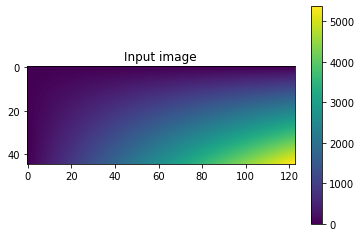

In [20]:
M          = 45    # --- Number of rows
N          = 123    # --- Number of cols

BLOCKSIZEX = 16
BLOCKSIZEY = 16

fftshift2D = mod.get_function("fftshift2DKernel")

blockDim  = (BLOCKSIZEX, BLOCKSIZEY, 1)
gridDim   = (int(iDivUp(N, BLOCKSIZEX)), int(iDivUp(M, BLOCKSIZEY)), 1)

x         = range(N)
y         = range(M)
X, Y      = np.meshgrid(x, y)

img       = X * Y
img       = np.asarray(img, float)

plt.figure(1)
plt.imshow(img)
plt.colorbar()
plt.title('Input image')

print(img.dtype)

Moving the data to the device and allocating space for the result.

In [0]:
# --- Move the image from host to device
d_img  = cuda.mem_alloc(img.nbytes)
cuda.memcpy_htod(d_img, img)
d_img2 = cuda.mem_alloc(img.nbytes)

Operating the 2D fftshift.

Text(0.5, 1.0, 'Output image')

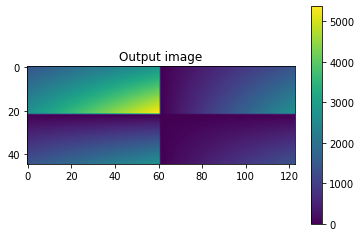

In [22]:
fftshift2D(d_img, d_img2, np.int32(M), np.int32(N), block = blockDim, grid = gridDim)

img2   = np.empty_like(img)
cuda.memcpy_dtoh(img2, d_img2)

plt.figure(2)
plt.imshow(img2)
plt.colorbar()
plt.title('Output image')

Comparison of implemented 2D ```fftshift``` with numpy ```ffthisft```.

In [23]:
print(LA.norm(np.fft.fftshift(img) - img2))

0.0
